In [1]:
import pfv_utils.utils as pu
import vision.data.proto.annotated_image_pb2
import vision.data.proto.oriented_bounding_box_annotation_extension_pb2
import vision.data.tools.fiducial_annotator.fiducial_annotator_pb2
import tensorflow as tf
import numpy as np

In [2]:
reload(pu)

<module 'pfv_utils.utils' from 'pfv_utils/utils.py'>

In [3]:
net = pu.BikeOrientationNet(input_dim=64)

In [4]:
bike_lmdbs_dir = '/mnt/sun-pcs01/praveen/pfv_bikes/train_lmdbs_64_bf_0.1/'
bike_lmdb_paths = pu.get_sorted_lmdb_paths_in_dir(bike_lmdbs_dir)

In [5]:
#hard_bike_lmdbs_dir = '/mnt/nautilus_rw/praveen/pfv/2018/10/13/bike_ori_hard_mining_64/'
#hard_bike_lmdb_paths = pu.get_sorted_lmdb_paths_in_dir(hard_bike_lmdbs_dir)

In [6]:
all_bike_lmdb_paths = bike_lmdb_paths #bike_lmdb_paths + hard_bike_lmdb_paths
print len(all_bike_lmdb_paths)

9


In [7]:
bike_lmdbs = [pu.LMDBIterator(f) for f in all_bike_lmdb_paths]

In [8]:
bike_ai = vision.data.proto.annotated_image_pb2.AnnotatedImage()
bike_ai.ParseFromString(bike_lmdbs[7].kv_pair[1])

9001

In [9]:
pu.get_bike_gt_ori_idx_from_ai(bike_ai)

7

In [10]:
import matplotlib.pyplot as plt

In [11]:
%matplotlib inline

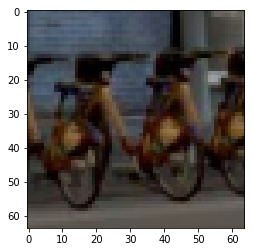

In [12]:
plt.imshow(pu.get_image_from_ai(bike_ai))

In [13]:
batch_size = 1

In [14]:
import time

In [15]:
reload(pu)

<module 'pfv_utils.utils' from 'pfv_utils/utils.py'>

In [16]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(net.loss)

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
iter = 0


In [ ]:
losses = []
while iter < 1000000:
    start = time.time()
    # Compose batch from extent_lmdbs.
    batch_ims = []
    full_batch_size = batch_size* (len(bike_lmdbs))
    batch_bike_gts = np.zeros(full_batch_size,dtype=np.int32)
    
    batch_item_idx = -1
    for bike_lmdb_idx, bike_lmdb in enumerate(bike_lmdbs):
        for i in range(0,batch_size):
            batch_item_idx +=1
            ai = vision.data.proto.annotated_image_pb2.AnnotatedImage()
            ai.ParseFromString(bike_lmdb.kv_pair[1])
            bike_lmdb.next()
            
            batch_ims.append(pu.get_image_from_ai(ai))
            batch_bike_gts[batch_item_idx] = pu.get_bike_gt_ori_idx_from_ai(ai)
            #assert (bike_lmdb_idx == batch_bike_gts[batch_item_idx])
                  

    normalized_batch_ims = pu.normalize_ims(np.array(batch_ims))
    end = time.time()
    loss, _ = sess.run([net.loss, train_step], feed_dict={net.x: normalized_batch_ims,
                                          net.y: batch_bike_gts
                                                              })
    losses.append(loss)
    step_end = time.time()

    assert(loss.shape == ())
    if iter % 1000 == 0:
        print 'On iter: %d; loss: %0.2f step time: %f' % (iter, loss, step_end-end)

            
    iter+=1
    
    

On iter: 0; loss: 46.11 step time: 3.462421
On iter: 1000; loss: 20.39 step time: 0.003438
On iter: 2000; loss: 19.92 step time: 0.004033
On iter: 3000; loss: 16.89 step time: 0.003973
On iter: 4000; loss: 15.10 step time: 0.004762
On iter: 5000; loss: 17.11 step time: 0.003570
On iter: 6000; loss: 14.76 step time: 0.004442
On iter: 7000; loss: 12.96 step time: 0.003854
On iter: 8000; loss: 17.27 step time: 0.004435
On iter: 9000; loss: 13.64 step time: 0.004594
On iter: 10000; loss: 15.88 step time: 0.004554
On iter: 11000; loss: 12.94 step time: 0.004123
On iter: 12000; loss: 13.31 step time: 0.004322
On iter: 13000; loss: 14.50 step time: 0.003747
On iter: 14000; loss: 13.40 step time: 0.003978
On iter: 15000; loss: 11.98 step time: 0.004242
On iter: 16000; loss: 12.40 step time: 0.003930
On iter: 17000; loss: 10.17 step time: 0.003389
On iter: 18000; loss: 14.34 step time: 0.003944
On iter: 19000; loss: 10.38 step time: 0.004289
On iter: 20000; loss: 8.80 step time: 0.003738
On ite

In [ ]:
graphdef = sess.graph_def
frozen_graph = tf.graph_util.convert_variables_to_constants(sess, graphdef, ["output"])
converted_graph_def= tf.graph_util.remove_training_nodes(frozen_graph)
tf.train.write_graph(converted_graph_def, "/mnt/nautilus_rw/praveen/", "bike_ori_model_64_bf_0.1_with_dim_16_dropout.pb", as_text=False)

In [ ]:
l_slice = np.array(losses[1000:])
plt.plot(np.arange(len(l_slice)), l_slice)

In [ ]:
#with open('/home/praveen/bike_ori_model.pb', 'wb') as of:
#    of.write(sess.graph_def.SerializeToString())

In [ ]:
x=1

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
normalized_batch_ims.shape

In [ ]:
pred = sess.run([net.output_logits], {net.x: normalized_batch_ims})[0]
arg_preds = np.argmax(pred, 1)

In [ ]:
plt.figure(figsize=(10,10))
for i,im in enumerate(normalized_batch_ims):
    plt.subplot(3,3,i+1)
    plt.imshow( im + 0.5);
    plt.title('i: %d pred: %d' % (i, arg_preds[i]))